In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

C:\Users\kuinc\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dir = '../Data/train/'
test_dir = '../Data/test/'
img_height = 480
img_width = 640

In [3]:
train_imgs = tf.keras.utils.image_dataset_from_directory(
    train_dir + "images",
    labels=None,
    #validation_split=0.2,
    #subset="training",
    shuffle=False,
    seed=100,
    image_size=(img_height, img_width),
    batch_size=None)

Found 153 files belonging to 1 classes.


In [4]:
train_masks = tf.keras.utils.image_dataset_from_directory(
    train_dir + "masks",
    labels=None,
    #validation_split=0.2,
    #subset="training",
    shuffle=False,
    seed=100,
    image_size=(img_height, img_width),
    batch_size=None)

Found 153 files belonging to 1 classes.


In [5]:
test_imgs = tf.keras.utils.image_dataset_from_directory(
    test_dir + "images",
    labels=None,
    #validation_split=0.2,
    #subset="training",
    shuffle=False,
    seed=100,
    image_size=(img_height, img_width),
    batch_size=None)

Found 40 files belonging to 1 classes.


In [6]:
test_masks = tf.keras.utils.image_dataset_from_directory(
    test_dir + "masks",
    labels=None,
    #validation_split=0.2,
    #subset="training",
    shuffle=False,
    seed=100,
    image_size=(img_height, img_width),
    batch_size=None)

Found 40 files belonging to 1 classes.


In [7]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    input_mask = tf.image.rgb_to_grayscale(input_mask)
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    input_mask = tf.round(input_mask)
    #input_mask -= 1
    
    return input_image, input_mask

In [8]:
train_img_iter = iter(train_imgs)
train_msk_iter = iter(train_masks)

def train_map(file_path):
    input_image = next(train_img_iter)
    input_mask = next(train_msk_iter)
    
    input_image = tf.image.resize(input_image, (128, 128))
    input_mask = tf.image.resize(input_mask, (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [9]:
round(0.999999,1)

1.0

In [10]:
test_img_iter = iter(test_imgs)
test_msk_iter = iter(test_masks)

def test_map(file_path):
    input_image = next(test_img_iter)
    input_mask = next(test_msk_iter)
    
    input_image = tf.image.resize(input_image, (128, 128))
    input_mask = tf.image.resize(input_mask, (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_imgs = train_imgs.map(train_map, num_parallel_calls=AUTOTUNE)
test_imgs = test_imgs.map(test_map, num_parallel_calls=AUTOTUNE)

In [12]:
type(train_imgs)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [13]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [14]:
TRAIN_LENGTH = len(train_imgs)
BATCH_SIZE = 10
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [15]:
train_batches = (
    train_imgs
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = (
    test_imgs
    .repeat()
    .batch(BATCH_SIZE))

In [16]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

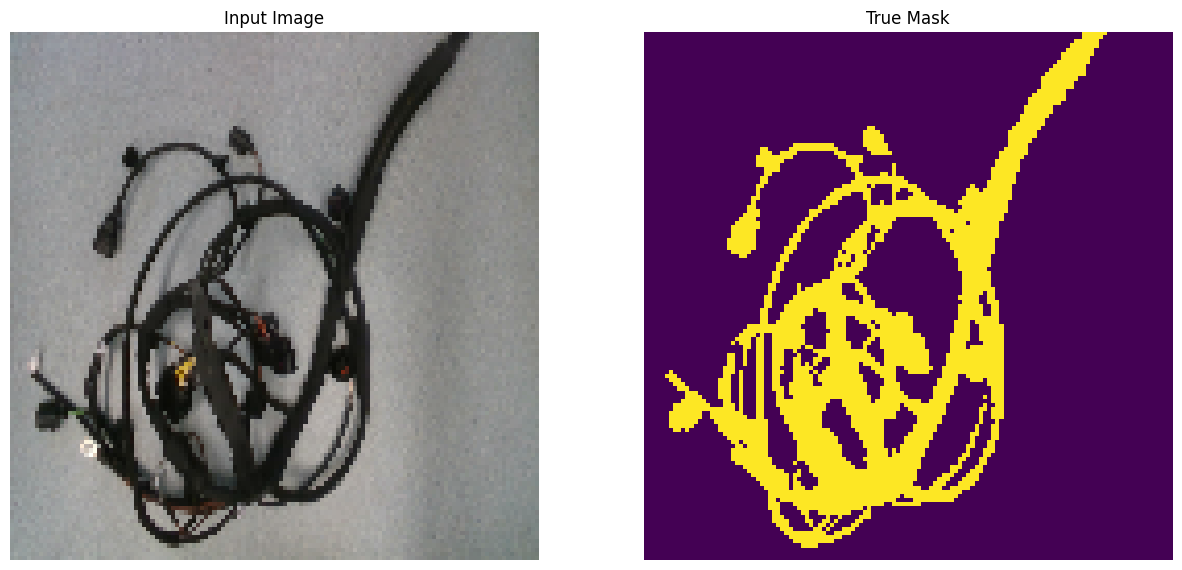

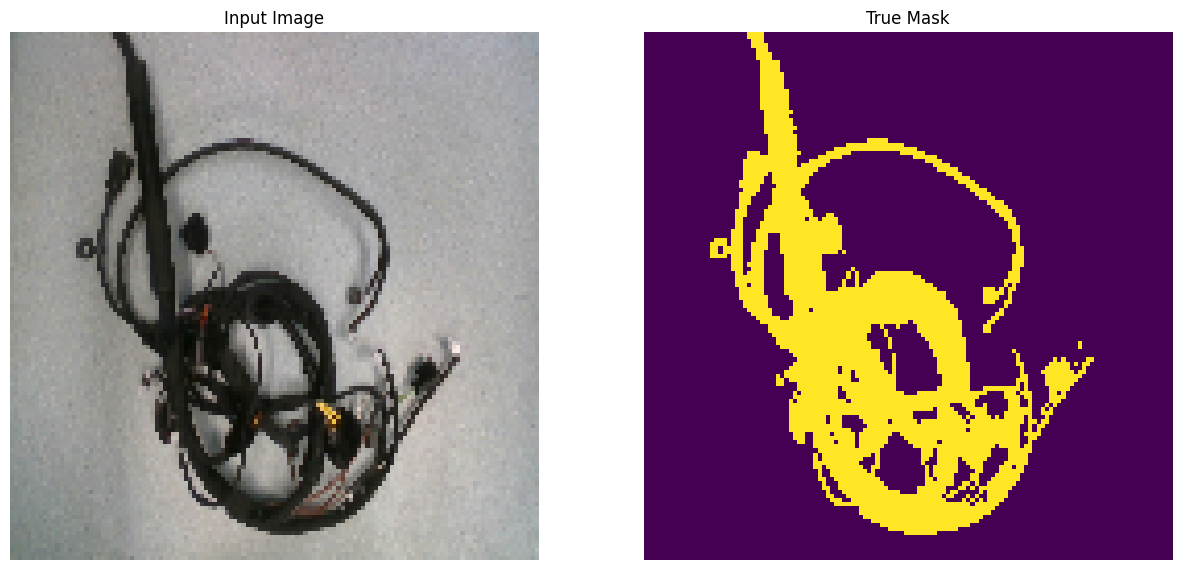

In [17]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [19]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [23]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [24]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 3s 3s/step


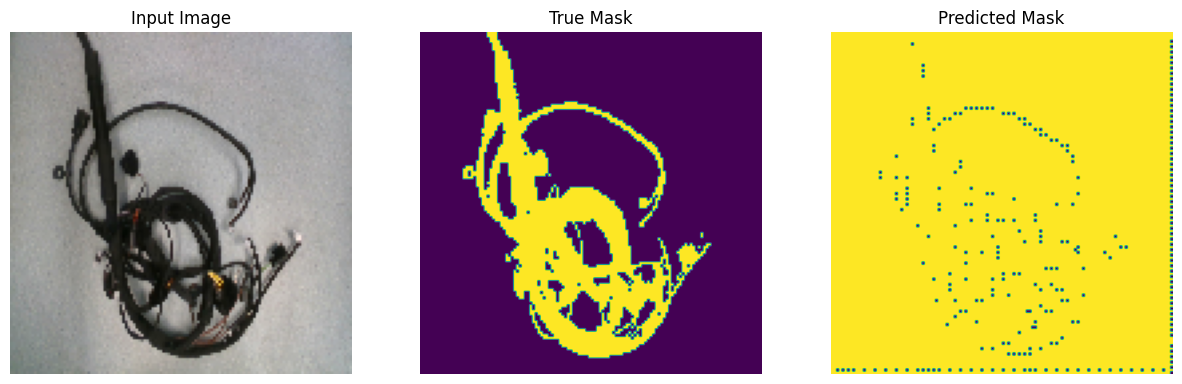

In [25]:
show_predictions()

In [26]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [27]:
EPOCHS = 20
VAL_SUBSPLITS = 2
#VALIDATION_STEPS = len(test_batches)//BATCH_SIZE//VAL_SUBSPLITS

1/1 [==============================] - 0s 16ms/step


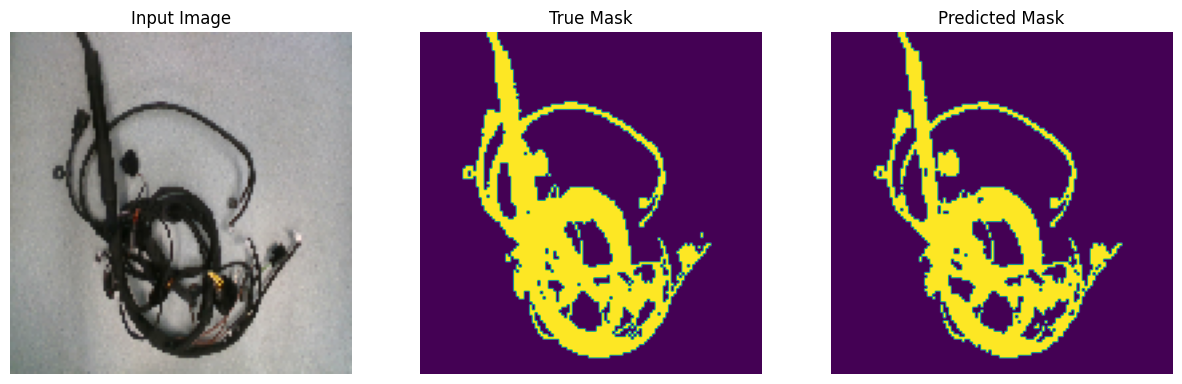


Sample Prediction after epoch 20

15/15 [==============================] - 1s 50ms/step - loss: 0.1155 - accuracy: 0.9567


In [28]:
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          #steps_per_epoch=None,
                          validation_steps=0,
                          #validation_steps=None,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

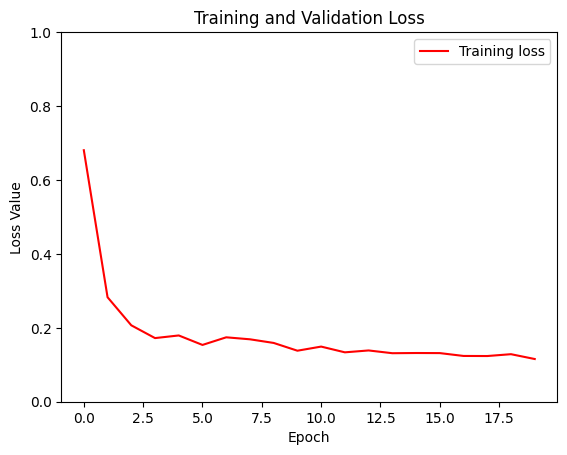

In [29]:
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
#plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 0s 18ms/step


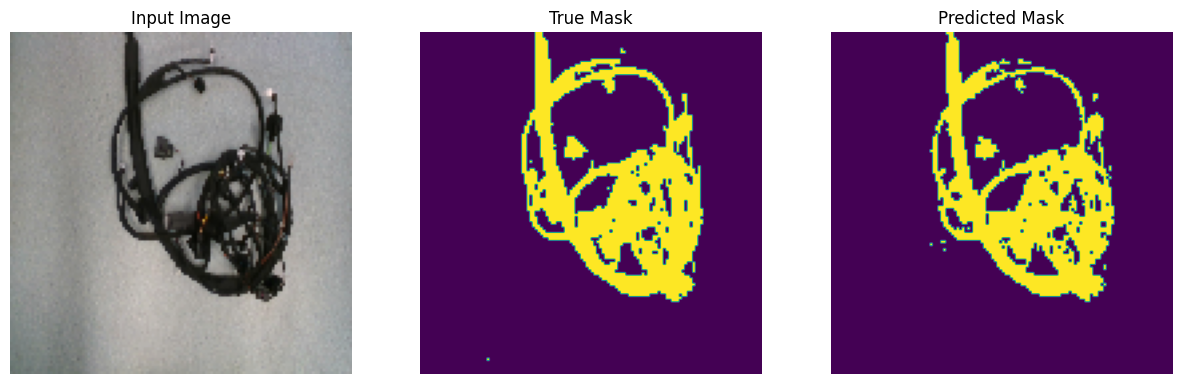

In [30]:
show_predictions(train_batches, 1)

In [31]:
wire = tf.keras.utils.load_img(
    "wire.jpg",
    #grayscale=False,
    color_mode='rgb',
    target_size=(128,128),
    interpolation='nearest',
    keep_aspect_ratio=False
)

In [32]:
wire_arr = tf.keras.utils.img_to_array(wire, data_format=None, dtype=None)

In [33]:
wire_tensor = tf.convert_to_tensor(wire_arr)

In [34]:
wire_tensor = tf.cast(wire_tensor, tf.float32) / 255.0

In [35]:
dataset = tf.data.Dataset.from_tensors([wire_tensor])

In [36]:
dataset

<TensorDataset element_spec=TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None)>

1/1 [==============================] - 0s 14ms/step


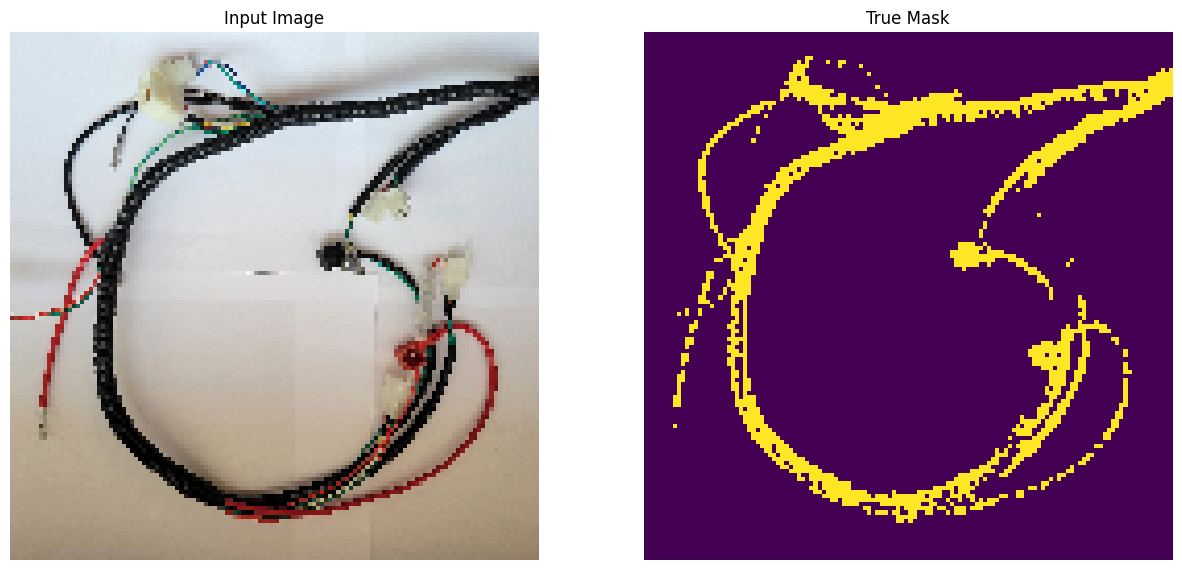

In [37]:
display([wire, create_mask(model.predict(dataset))])